## Using RBM for denoising a correlation matrix

Here we generate data from an RBM with k hidden units using weights of our choosing and then try to learn this data from an RBM which has only 1 hidden unit - say it requires S samples. We also try to learn this data from another RBM with k or less hidden units and check if the weights are a linear combination of the original weights (that is if the RBM finds the same direction or a linear combination of the original directions), and we see if we require less than S samples for this RBM. One might need special potentials like the RelU for this.

This is essentially trying to find multiple directons in the data set with less number of samples than will be required by the linear analysis (one hidden unit RBM) which mighjt require the use of special potentials.


OLD IDEA: Here we use an RBM to learn a data set limited by the number of samples and then we geenrate samples using this trained RBM and check if we can now use less samples to learn the matrix or if the top eigenvector of this matrix is ordered at less number of samples. This is in effect denoising the correlation matrix.

This may work by using multiple hidden units with fields so the RBM uses more information than from only the top eigenvector of the matrix. Its a paper by Remi Monasson.

In [2]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [3]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/24_denoising_studentTeacherRBM-2')

In [4]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/24_denoising_studentTeacherRBM-2')

In [70]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

N = 100
beta = 0.5
Num_configs = 10000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings =  beta* (np.eye(N=N,k=1) + np.eye(N=N,k=-1) )
BM.layer.couplings[0,-1] += beta
BM.layer.couplings[-1,0] += beta

#data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=400) # N steps.

#Estimate Correlations for number of MC steps
#plt.plot(data.mean(1)[0:-1]);plt.show()

## Generate data from a RBM:

k hidden units, the weights are gaussians centred at different values on different channels:

In [69]:
from scipy.stats import norm
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import scipy as sc
import numdifftools as nd
from scipy.stats import multivariate_normal

In [148]:
RBM_gen = rbm.RBM(visible='Spin', n_v=N, n_h=5,hidden ='Spin',zero_field = True)

for i in np.arange(RBM_gen.n_h-1):
    RBM_gen.weights[i] = 2*norm.pdf(x=np.linspace(0,99,100),loc=20*i+5,scale=2)

RBM_gen.weights[4] = 2.5*norm.pdf(x=np.linspace(0,99,100),loc=20*4+5,scale=2)
data_gen = RBM_gen.gen_data(Nchains=1,Lchains=10000,Nthermalize=0,Nstep=100,N_PT=1,config_init=[],beta=1,batches=None,reshape=True)

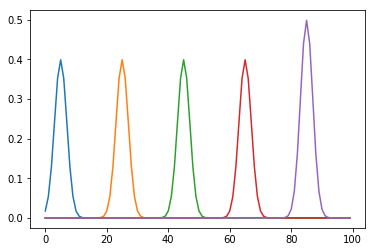

In [147]:
plt.plot(RBM_gen.weights.T)

## Train a single hidden unit RBM:

In [149]:
data_genA = np.zeros([len(data_gen[0]),len(data_gen[0][0])])
for i in np.arange(len(data_gen[0])):
    data_genA[i,:] = data_gen[0][i]

In [150]:
# Top Eignvectors of the C_ij matrix:
def topEV(data,method='Covariance'):
    if method is 'Covariance':
        #Find the covariance matrix:
        covMAT = np.cov(data)
    elif method is 'Correlation':
        covMAT = np.corrcoef(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec[:,np.argmax(Eval)],np.max(Eval)

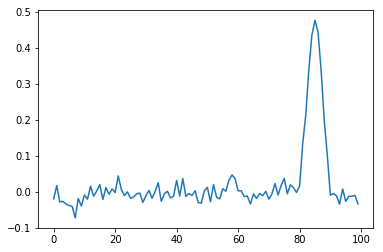

In [151]:
data_genA_Evec = np.zeros(len(data_genA[0]))
data_genA_Evec,_ = topEV(data_genA.T,method='Correlation')
plt.plot(range(len(data_genA[0])),data_genA_Evec)

In [152]:
RBM_unity     = []
results_unity = []
j = 0

for i in np.array([100,120,140,160,180,200,500,1000,5000,10000]):

    RBM_unity.append(rbm.RBM(visible = 'Spin', n_v=N, n_h = 1, hidden = 'Spin',zero_field = True))
    results_unity.append(RBM_unity[j].fit(data_genA[0:i],n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],\
                                 record_interval=100,batch_size=20,N_MC= 20, lr_decay=False,batch_norm=False));
    j += 1

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting epoch 70
Starting epoch 71
Starting epoch 72
Starting epoch 73
Starting epoch 74
Starting epoch 75
Starting epoch 76
Starting epoch 77
Starting epoch 78
Starting epoch 79
Starting epoch 80
Starting epoch 81
Starting epoch 82
Starting epoch 83
Starting epoch 84
Starting epoch 85
Starting epoch 86
Starting epoch 87
Starting epoch 88
Starting epoch 89
Starting epoch 90
Starting epoch 91
Starting epoch 92
Starting epoch 93
Starting epoch 94
Starting epoch 95
Starting epoch 96
Starting epoch 97
Starting epoch 98
Starting epoch 99
Starting epoch 100
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14


Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
Starting epoch 57
Starting epoch 58
Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting epoch 70
Starting epoch 71
Starting e

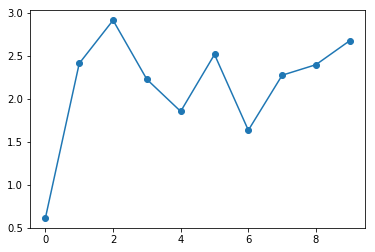

In [154]:
sumWeights_unity = np.zeros(len(RBM_unity))
for i in np.arange(len(RBM_unity)):
    sumWeights_unity[i] = (abs(np.sum(np.array(results_unity[i]['W'])[-1,0,:])))
    
plt.figure()
plt.plot(sumWeights_unity,'o-')

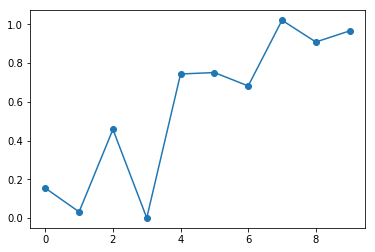

In [155]:
# Plot overlap with top eigenvector:
overlap_unity = np.zeros(len(RBM_unity))
for i in np.arange(len(RBM_unity)):
    overlap_unity[i] = (np.dot(np.array(results_unity[i]['W'])[-1,0,:],data_genA_Evec))
    
plt.figure()
plt.plot(abs(overlap_unity),'o-')

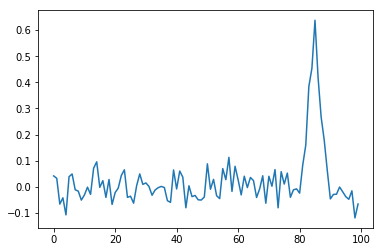

In [174]:
plt.plot(np.array(results_unity[7]['W'])[-1,0,:])

## Train a RBM with multiple Units (Spin Units):

In [153]:
RBM_many     = []
results_many = []
j = 0

for i in np.array([100,120,140,160,180,200,500,1000,5000,10000]):

    RBM_many.append(rbm.RBM(visible = 'Spin', n_v=N, n_h = 5, hidden = 'Spin',zero_field = True))
    results_many.append(RBM_many[j].fit(data_genA[0:i],n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],\
                                 record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False));
    j += 1

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting epoch 70
Starting epoch 71
Starting epoch 72
Starting epoch 73
Starting epoch 74
Starting epoch 75
Starting epoch 76
Starting epoch 77
Starting epoch 78
Starting epoch 79
Starting epoch 80
Starting epoch 81
Starting epoch 82
Starting epoch 83
Starting epoch 84
Starting epoch 85
Starting epoch 86
Starting epoch 87
Starting epoch 88
Starting epoch 89
Starting epoch 90
Starting epoch 91
Starting epoch 92
Starting epoch 93
Starting epoch 94
Starting epoch 95
Starting epoch 96
Starting epoch 97
Starting epoch 98
Starting epoch 99
Starting epoch 100
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14


Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
Starting epoch 57
Starting epoch 58
Starting epoch 59
Starting epoch 60
Starting epoch 61
Starting epoch 62
Starting epoch 63
Starting epoch 64
Starting epoch 65
Starting epoch 66
Starting epoch 67
Starting epoch 68
Starting epoch 69
Starting epoch 70
Starting epoch 71
Starting e

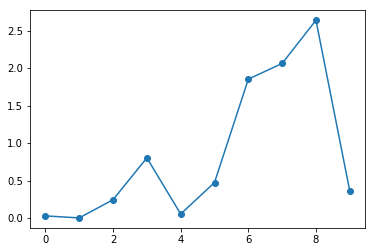

In [164]:
sumWeights_many = np.zeros([len(RBM_many),RBM_many[0].n_h])
for i in np.arange(len(RBM_many)):
    sumWeights_many[i] = (abs(np.sum(np.array(results_many[i]['W'])[-1,:,:],axis=1)))
    
plt.figure()
plt.plot(sumWeights_many[:,3],'o-')

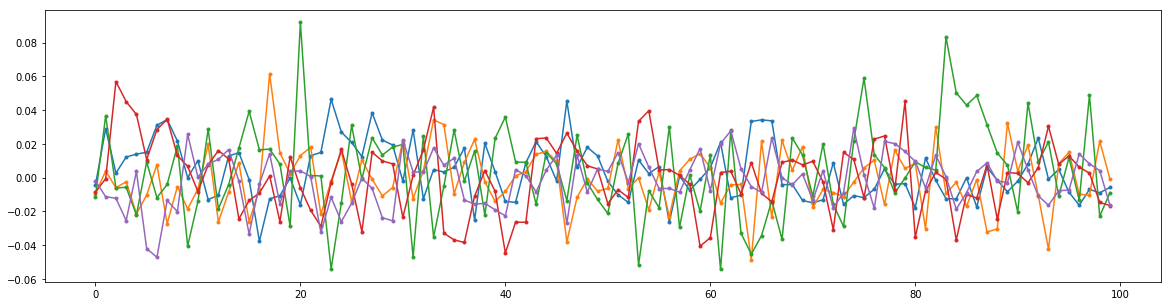

In [179]:
plt.figure(figsize=(20,5))
plt.plot(np.array(results_many[4]['W'])[-1,:,:].T,'.-')

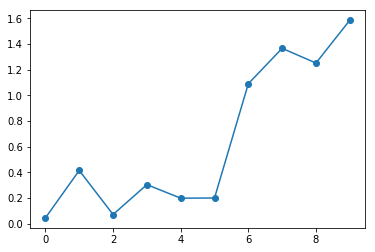

In [167]:
# Plot overlap with top eigenvector:
overlap_many = np.zeros([len(RBM_many),RBM_many[0].n_h])
for i in np.arange(len(RBM_many)):
    for j in np.arange(RBM_many[0].n_h):
        overlap_many[i,j] = (np.dot(np.array(results_many[i]['W'])[-1,j,:],data_genA_Evec))
plt.figure()
plt.plot(np.sum(abs(overlap_many),axis=1),'o-')

## Train a RBM with multiple Units (ReLU Units):

In [177]:
RBM_many2     = []
results_many2 = []
j = 0

for i in np.array([100,120,140,160,180,200,500,1000,5000,10000]):

    RBM_many2.append(rbm.RBM(visible = 'Spin', n_v=N, n_h = 5, hidden = 'ReLU',zero_field = False))
    results_many2.append(RBM_many2[j].fit(data_genA[0:i],n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],\
                                 record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False));
    j += 1

Starting epoch 1


KeyError: 'a0'